# Loading data

In [ ]:
import numpy as np
from scipy.signal import welch

In [3]:
import pickle

train_df = pickle.load(open("data_new/epoched_train.pkl", "rb"))

test_df = pickle.load(open("data_new/epoched_test.pkl", "rb"))

In [4]:
train_df.columns

Index(['patient_id', 'start_time', 'event_type', 'C3', 'Cz', 'C4', 'EOG:ch01',
       'EOG:ch02', 'EOG:ch03'],
      dtype='object')

# Preprocessing functions

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

def stack_channel_data(df, channel_names):
    # No modifications needed here.
    channel_arrays = [np.stack(df[ch].values, axis=0) for ch in channel_names]
    stacked = np.stack(channel_arrays, axis=-1)
    return stacked.reshape(-1, len(channel_names))

def segment_data(data, trial_length):
    # No modifications needed here.
    n_trials = data.shape[0] // trial_length
    return [data[i*trial_length:(i+1)*trial_length, :] for i in range(n_trials)]

def bandpass_filter(data, lowcut, highcut, fs):
    # No modifications needed here.
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Applying ICA

In [6]:
def stable_sigmoid(x):
    # Clip x to avoid overflow
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def infoMaxICA(X, lr=0.001, max_iter=1000, tol=1e-5):
    """
    Perform ICA using the InfoMax algorithm with stability improvements.
    
    Parameters:
      X       : np.ndarray of shape (n_components, n_samples) (assumed to be centered and whitened)
      lr      : Learning rate (step size)
      max_iter: Maximum number of iterations
      tol     : Tolerance for convergence
      
    Returns:
      W       : The estimated unmixing matrix.
      S       : The separated (independent) components, S = W @ X.
    """
    n, T = X.shape
    # Initialize W as a random matrix
    W = np.random.randn(n, n)
    
    for i in range(max_iter):
        # Compute estimated sources
        Y = W @ X  # Shape: (n, T)
        # Use the stable sigmoid
        gY = stable_sigmoid(Y)
        # InfoMax update rule
        dW = lr * (np.eye(n) + (1 - 2 * gY) @ Y.T) @ W
        W_new = W + dW
        
        # Normalize rows of W_new to help with numerical stability
        W_new = W_new / np.linalg.norm(W_new, axis=1, keepdims=True)
        
        # Check for convergence
        if np.linalg.norm(dW) < tol:
            print(f"Converged at iteration {i}")
            W = W_new
            break
        
        W = W_new
    
    S = W @ X
    return W, S

In [7]:
def fastICA(X, n_components=6, tol=1e-5, max_iter=1000):
    """
    FastICA implementation using fixed-point iteration (manual implementation).

    Parameters:
        X : array-like, shape (n_samples, n_features)
            The observed mixed signals.
        n_components : int
            The number of independent components to extract.
        tol : float, optional
            Convergence tolerance.
        max_iter : int, optional
            Maximum number of iterations per component.

    Returns:
        S : array-like, shape (n_samples, n_components)
            Estimated source signals.
        W : array-like, shape (n_components, n_features)
            Estimated unmixing matrix.
    """
    X_centered = X - np.mean(X, axis=0)

    cov = np.cov(X_centered, rowvar=False)

    d, E = np.linalg.eigh(cov)

    idx = np.argsort(d)[::-1]
    d = d[idx]
    E = E[:, idx]

    D_inv = np.diag(1.0 / np.sqrt(d))
    whitening_matrix = D_inv @ E.T
    X_whitened = X_centered @ whitening_matrix.T

    n_samples, n_features = X_whitened.shape
    W = np.zeros((n_components, n_features))

    for i in range(n_components):
        w = np.random.rand(n_features)
        w /= np.linalg.norm(w)

        for iteration in range(max_iter):
            wx = np.dot(X_whitened, w)
            g = np.tanh(wx)
            g_prime = 1 - np.tanh(wx) ** 2

            w_new = np.mean(X_whitened * g[:, np.newaxis], axis=0) - np.mean(g_prime) * w

            if i > 0:
                w_new -= np.dot(np.dot(W[:i], w_new), W[:i])

            w_new /= np.linalg.norm(w_new)

            if np.abs(np.abs(np.dot(w_new, w)) - 1) < tol:
                break
            w = w_new

        W[i, :] = w_new

    S = np.dot(X_whitened, W.T)
    return W, S

In [8]:
def compute_correlations(ica_sources, channels):
    """
    Compute the Pearson correlation coefficients between each ICA component
    and each EEG and/or EOG channel.
    
    Parameters
    ----------
    ica_sources : np.array, shape (n_samples, n_components)
        The ICA source signals.
    channels : np.array, shape (n_samples, n_eog)
        The filtered channel data.
        
    Returns
    -------
    corr_matrix : np.array, shape (n_components, n_eog)
        Each entry (i, j) is the correlation coefficient between component i
        and channel j.
    """
    n_components = ica_sources.shape[1]
    n_channels = channels.shape[1]
    
    corr_matrix = np.zeros((n_components, n_channels))
    
    for comp_idx in range(n_components):
        for ch_idx in range(n_channels):
            corr_matrix[comp_idx, ch_idx] = np.corrcoef(ica_sources[:, comp_idx],
                                                         channels[:, ch_idx])[0, 1]
    return corr_matrix

def identify_bad_components(ica_sources, eog_data):
    corr_matrix = compute_correlations(ica_sources, eog_data)
    # Identify artifact components by correlating each IC with each EOG channel
    artifact_components = []
    corr_threshold = 0.4  # or any threshold you deem appropriate
    
    for comp_idx in range(ica_sources.shape[1]):
        comp_corrs = np.abs(corr_matrix[comp_idx, :])
        if np.any(comp_corrs > corr_threshold):
            artifact_components.append(comp_idx)

    print("Identified artifact ICA components:", artifact_components)
    return corr_matrix, artifact_components

In [ ]:
def whiten(X):
    """
    Whiten the observed signals.
    Input:
      X: array of shape (n_channels, n_samples)
    Returns:
      X_white: whitened data
      whitening_matrix: matrix used for whitening
    """

    X_centered = X - np.mean(X, axis=1, keepdims=True)

    cov = np.cov(X_centered)

    d, E = np.linalg.eigh(cov)

    idx = d.argsort()[::-1]
    d = d[idx]
    E = E[:, idx]

    D_inv = np.diag(1.0 / np.sqrt(d))
    whitening_matrix = D_inv @ E.T
    X_white = whitening_matrix @ X_centered
    return X_white, whitening_matrix


def compute_covariance_matrices(X, max_lag):
    """
    Compute covariance matrices at multiple time delays for the whitened signals.
    Input:
      X: whitened data of shape (n_channels, n_samples)
      max_lag: maximum time delay (tau) to use
    Returns:
      cov_matrices: list of covariance matrices for lags 1 ... max_lag
    """
    n_channels, n_samples = X.shape
    cov_matrices = []
    for tau in range(1, max_lag + 1):
        X1 = X[:, tau:]
        X2 = X[:, :n_samples - tau]
        R_tau = (X1 @ X2.T) / (n_samples - tau)
        R_tau = (R_tau + R_tau.T) / 2.0
        cov_matrices.append(R_tau)
    return cov_matrices


def joint_diagonalization(cov_matrices, eps=1e-6, max_iter=1000):
    """
    Joint diagonalization via iterative Givens rotations.
    Input:
      cov_matrices: list of covariance matrices to be jointly diagonalized
      eps: convergence threshold
      max_iter: maximum number of iterations
    Returns:
      V: the joint diagonalizer matrix
    """
    n_channels = cov_matrices[0].shape[0]
    V = np.eye(n_channels)

    for iteration in range(max_iter):
        change = 0
        for p in range(n_channels - 1):
            for q in range(p + 1, n_channels):
                g_sum = 0.0
                h_sum = 0.0
                for R in cov_matrices:
                    g_pp = R[p, p]
                    g_qq = R[q, q]
                    g_pq = R[p, q]

                    g_sum += 2 * g_pq
                    h_sum += (g_qq - g_pp)

                phi = 0.5 * np.arctan2(g_sum, h_sum + 1e-12)
                c = np.cos(phi)
                s = np.sin(phi)
                if np.abs(s) < eps:
                    continue

                J = np.eye(n_channels)
                J[p, p] = c
                J[q, q] = c
                J[p, q] = -s
                J[q, p] = s

                V = V @ J

                for i in range(len(cov_matrices)):
                    R = cov_matrices[i]
                    Rp = R[p, :].copy()
                    Rq = R[q, :].copy()
                    R[p, :] = c * Rp - s * Rq
                    R[q, :] = s * Rp + c * Rq

                    Rp = R[:, p].copy()
                    Rq = R[:, q].copy()
                    R[:, p] = c * Rp - s * Rq
                    R[:, q] = s * Rp + c * Rq
                    cov_matrices[i] = R
                change += np.abs(s)
        if change < eps:
            break
    return V


def sobiICA(X, max_lag=100):
    """
    Apply the SOBI algorithm to separate mixed signals.
    Input:
      X: observed data (n_channels x n_samples)
      max_lag: maximum time delay to consider for covariance estimation
    Returns:
      W: the matrix used to recover the sources
      S: estimated source signals
    """
    X_white, whitening_matrix = whiten(X)
    cov_matrices = compute_covariance_matrices(X_white, max_lag)
    U = joint_diagonalization(cov_matrices)
    W = U.T @ whitening_matrix
    S = W @ X
    return W, S

In [ ]:
def run_ica_on_filtered_data(filtered_X, ica_type=None, sfreq=250.0):
    """
    Run ICA on the filtered data and return a dictionary with ICA outputs.
    
    Parameters
    ----------
    filtered_X : np.ndarray, shape (n_times, n_channels)
        The filtered data. For example, (3680000, 6).
    ica_type : {'fastica', 'infomax', 'sobi', None}
        Which ICA method to use.
    sfreq : float, optional
        Sampling frequency (default 250 Hz).
    
    Returns
    -------
    dict with keys:
      - 'ica_sources': the ICA source signals, shape (n_times, n_components)
      - 'mixing_matrix': the mixing matrix, shape (n_channels, n_components)
      - 'artifact_components': indices of components identified as artifacts
      - 'ica_sources_clean': ICA sources after zeroing artifact components
      - 'cleaned_X': the reconstructed, cleaned data, shape (n_times, n_channels)
    """
    # Input filtered_X is expected in shape (n_times, n_channels).
    print("Input filtered_X shape:", filtered_X.shape)  # e.g. (3680000, 6)
    filtered_X_T = filtered_X.T  # Now shape (6, 3680000)
    
    # Create eog_data from filtered_X: select channels 3 to 5 from filtered_X_T, then transpose back.
    eog_data = filtered_X_T[3:, :].T  # Shape: (n_times, 3)
        
    # Run ICA using the chosen method.
    if ica_type == 'fastica':
        mixing_matrix, ica_sources = fastICA(filtered_X)
    elif ica_type == 'infomax':
        mixing_matrix, ica_sources = infoMaxICA(filtered_X)
    elif ica_type == 'sobi':
        mixing_matrix, ica_sources = sobiICA(filtered_X)
    else:
        # If no ICA is applied, return the original data.
        return {
            "ica_sources": None,
            "mixing_matrix": None,
            "artifact_components": None,
            "ica_sources_clean": None,
            "cleaned_X": filtered_X  # still in shape (n_times, n_channels)
        }
    
    # ica_sources has shape (n_times, n_components)
    artifact_components = identify_bad_components(ica_sources, eog_data, threshold=0.4)
    ica_sources_clean = ica_sources.copy()
    ica_sources_clean[:, artifact_components] = 0
    # Reconstruct cleaned signal: mixing_matrix (n_channels, n_components) @ ica_sources_clean.T (n_components, n_times)
    cleaned_X = mixing_matrix @ ica_sources_clean.T  # Shape: (n_channels, n_times)
    cleaned_X = cleaned_X.T  # Final shape: (n_times, n_channels)
    
    return {
        "ica_sources": ica_sources,
        "mixing_matrix": mixing_matrix,
        "artifact_components": artifact_components,
        "ica_sources_clean": ica_sources_clean,
        "cleaned_X": cleaned_X
    }

# Testing pipeline

In [85]:
def preprocess_stack_and_filter(df, 
                                eeg_channels=['C3', 'Cz', 'C4'], 
                                eog_channels=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], 
                                eeg_filter=(0.5, 30.0), 
                                eog_filter=(1.0, 5.0), 
                                sfreq=250.0):
    """
    Stack trials for EEG and EOG channels and apply FIR filtering separately.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame where each row is a trial and each cell for a given channel
        contains a 1D array of samples.
    eeg_channels : list of str, optional
        EEG channel names. Default is ['C3', 'Cz', 'C4'].
    eog_channels : list of str, optional
        EOG channel names. Default is ['EOG:ch01', 'EOG:ch02', 'EOG:ch03'].
    eeg_filter : tuple of float, optional
        (l_freq, h_freq) for EEG filtering. Default is (0.5, 30.0).
    eog_filter : tuple of float, optional
        (l_freq, h_freq) for EOG filtering. Default is (1.0, 5.0).
    sfreq : float, optional
        Sampling frequency. Default is 250.0 Hz.

    Returns
    -------
    filtered_X : np.ndarray
        Concatenated filtered EEG and EOG data, shape (n_times, n_channels_total).
    filtered_EEG : np.ndarray
        Filtered EEG data, shape (n_times, len(eeg_channels)).
    filtered_EOG : np.ndarray
        Filtered EOG data, shape (n_times, len(eog_channels)).
    """
    # Stack trials for EEG and EOG channels.
    EEG_data = stack_channel_data(df, eeg_channels)
    EOG_data = stack_channel_data(df, eog_channels)

    # 2. Apply bandpass filtering.
    filtered_EEG = bandpass_filter(EEG_data, eeg_filter[0], eeg_filter[1], sfreq)
    filtered_EOG = bandpass_filter(EOG_data, eog_filter[0], eog_filter[1], sfreq)

    # Concatenate filtered EEG and EOG data.
    filtered_X = np.concatenate([filtered_EEG, filtered_EOG], axis=1)
    
    return filtered_X

In [30]:
def main_pipeline(filtered_X,
                  y_true,
                  trial_length,
                  sfreq=250,
                  random_state=11):

    results = dict()
    for ica_type in ['fastica', 'infomax', 'sobi']:
        # 3. Run ICA independently.
        ica_results = run_ica_on_filtered_data(filtered_X, ica_type=ica_type)

        results[ica_type] = ica_results
    
    # Return all key outputs including ICA results.
    return results

# Visualization

In [62]:
def compute_epoched_psd(epoched_data, sfreq, n_fft, fmin, fmax):
    """
    Compute the PSD for each epoch using Welch's method.
    
    Parameters
    ----------
    epoched_data : np.ndarray, shape (n_epochs, n_times)
        The epoched signal (for one channel).
    sfreq : float
        Sampling frequency.
    n_fft : int
        Number of FFT points.
    fmin, fmax : float
        Frequency range for PSD.
        
    Returns
    -------
    psd_all : np.ndarray, shape (n_epochs, n_freqs)
        PSD for each epoch.
    freqs : np.ndarray
        Frequency bins.
    """
    psd_list = []
    for epoch in epoched_data:
        # psd_array_welch expects shape (n_channels, n_times)
        psd, freqs = psd_array_welch(epoch[None, :], sfreq=sfreq, n_fft=n_fft, fmin=fmin, fmax=fmax)
        psd_list.append(psd[0])
    return np.array(psd_list), freqs

In [89]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib as mpl
from scipy.signal import butter, filtfilt, lfilter
from scipy.stats import ttest_rel
from matplotlib.lines import Line2D
from mne.time_frequency import psd_array_welch


ICA_CM = {'fastica': 'RdBu',
          'infomax': 'PiYG',
          'sobi': 'PuOr'}

# =============================================================================
# 1. MNE Info and Montage Setup
# =============================================================================
def create_mne_info(ch_names, sfreq=250.0):
    """
    Create an MNE Info object using the last 6 channels of train_df.
    Assumes first 3 are EEG and last 3 are EOG.
    """
    ch_types = 3 * ['eeg'] + 3 * ['eog']
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    
    montage = mne.channels.make_standard_montage('standard_1020')
    info.set_montage(montage, match_case=False, on_missing='ignore')
    
    # Correct positions based on dataset description.
    channel_positions = {
        'C3': [-0.05, 0.0, 0.08],
        'Cz': [0.0, 0.0, 0.1],
        'C4': [0.05, 0.0, 0.08],
        'EOG:ch01': [0.0, 0.12, 0.0],
        'EOG:ch02': [0.05, 0.10, 0.0],
        'EOG:ch03': [-0.05, 0.10, 0.0],
    }
    for ch_name, pos in channel_positions.items():
        idx = info.ch_names.index(ch_name)
        info['chs'][idx]['loc'][:3] = pos
    # Ensure EOG channels are labeled correctly.
    info.set_channel_types({ch: 'eog' for ch in ['EOG:ch01', 'EOG:ch02', 'EOG:ch03']})
    return info

# =============================================================================
# 2. ICA Topomaps
# =============================================================================
def plot_component_topomaps(mixing, ica_type,
                            info, sphere=0.15):
    """
    Plot ICA component topomaps in a 2x3 grid with a unified color scale.
    
    Parameters
    ----------
    mixing : np.ndarray, shape (n_channels, n_components)
        The ICA mixing matrix.
    info : mne.Info
        MNE Info object with proper channel locations.
    sphere : float, optional
        The sphere radius for scaling (default: 0.15).
    cmap : str, optional
        Colormap (default: 'RdBu_r').
    """

    print(mixing.shape)
    mixing = mixing.T
    n_components = mixing.shape[1]
    eeg_idx = mne.pick_types(info, eeg=True, eog=True)
    pos = np.array([info['chs'][i]['loc'][:2] for i in eeg_idx])
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle("Topomaps of ICA components", fontsize=16, fontweight='bold')
    
    # Unified color scale across components.
    vmax = np.max(np.abs(mixing))
    vlim = (-vmax, vmax)
    
    for comp in range(n_components):
        ax = axes[comp // 3, comp % 3]
        data_comp = mixing[:, comp]
        im, _ = mne.viz.plot_topomap(
            data_comp, pos, axes=ax, show=False, cmap=ICA_CM[ica_type],
            vlim=vlim, sphere=(0.0, 0.0, 0.0, sphere)
        )
        ax.set_title(f'Component {comp}', fontsize=14)
    
    # Create a single colorbar for all subplots.
    cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label("Component Weight Strength", fontsize=12, labelpad=10)
    
    fig.subplots_adjust(hspace=0.2, top=0.87)
    plt.savefig(f'images/psd_comparison.png', bbox_inches='tight', dpi=300)

# =============================================================================
# 3. Power Spectral Density (PSD) Comparison
# =============================================================================

def plot_psd_ratio(filtered_EEG, fastica_EEG, infomax_EEG, sobi_EEG, channels, sfreq=250, n_fft=512):
    """
    Plot PSD ratio (original / cleaned) for each EEG channel in a figure with 3 rows
    (one row per ICA method) x len(channels) columns.
    
    Parameters
    ----------
    filtered_EEG : np.ndarray, shape (n_channels, n_times)
        Original EEG data.
    fastica_EEG : np.ndarray, shape (n_channels, n_times)
        FastICA-cleaned EEG data.
    infomax_EEG : np.ndarray, shape (n_channels, n_times)
        Infomax-cleaned EEG data.
    sobi_EEG : np.ndarray, shape (n_channels, n_times)
        SOBI-cleaned EEG data.
    channels : list of str
        Channel names (e.g. ['C3', 'Cz', 'C4']).
    sfreq : float, optional
        Sampling frequency.
    n_fft : int, optional
        Number of FFT points.
    """
    print(filtered_EEG.shape, fastica_EEG.shape)
    # Compute PSD for each dataset.
    # Note: psd_array_welch expects data in shape (n_channels, n_times) for continuous data.
    psd_orig, freqs = psd_array_welch(filtered_EEG.T, sfreq=sfreq, fmin=0.5, fmax=30.0, n_fft=n_fft)
    psd_fastica, _ = psd_array_welch(fastica_EEG.T, sfreq=sfreq, fmin=0.5, fmax=30.0, n_fft=n_fft)
    psd_infomax, _ = psd_array_welch(infomax_EEG.T, sfreq=sfreq, fmin=0.5, fmax=30.0, n_fft=n_fft)
    psd_sobi, _ = psd_array_welch(sobi_EEG.T, sfreq=sfreq, fmin=0.5, fmax=30.0, n_fft=n_fft)

    # Each PSD array is of shape (n_channels, n_freqs)
    psd_cleaned_list = [psd_fastica, psd_infomax, psd_sobi]

    n_channels = len(channels)
    ch_colors = ['crimson', 'yellowgreen', 'purple']  # one color per channel

    fig, axes = plt.subplots(nrows=3, ncols=n_channels, figsize=(4*n_channels, 8), sharex=True, sharey=True)
    fig.suptitle("PSD Ratio (Original / Cleaned)", fontsize=16, fontweight='bold')

    methods = ['FastICA', 'Infomax', 'SOBI']
    # Iterate over each ICA method (row)
    for row_idx, method in enumerate(methods):
        psd_clean = psd_cleaned_list[row_idx]
        # Compute ratio: use np.where to avoid division by zero; then clip extreme values.
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = np.where(psd_clean != 0, psd_orig / psd_clean, np.nan)

        # Plot for each channel
        for col_idx in range(n_channels):
            ax = axes[row_idx, col_idx]
            ax.plot(freqs, ratio[col_idx, :], color=ch_colors[col_idx], lw=2)
            ax.axhline(1.0, color='gray', linestyle='--', lw=1)

            if row_idx == 0:
                ax.set_title(f"{channels[col_idx]}", fontsize=14, fontweight='bold', pad=10)
            if col_idx == 0:
                ax.set_ylabel(f"{method}", fontsize=14, fontweight='bold', labelpad=10)
            
            ax.grid(alpha=0.4)
            ax.spines[['top', 'right']].set_visible(False)
            if row_idx == 2:
                ax.set_xlabel("Frequency (Hz)", fontsize=12)

    fig.tight_layout(rect=[0, 0, 1, 0.97], h_pad=2)
    plt.savefig("images/psd_ratio.png", bbox_inches="tight", dpi=300)
    plt.show()

# =============================================================================
# 4. EOG-EEG Correlation in Ocular Frequency Band
# =============================================================================

def compute_mean_abs_correlation(signal1, signal2):
    """
    Compute the mean absolute Pearson correlation between each column of signal1 and each column of signal2.
    
    Parameters
    ----------
    signal1 : np.ndarray, shape (n_samples, n_channels1)
    signal2 : np.ndarray, shape (n_samples, n_channels2)
    
    Returns
    -------
    float
        Mean absolute correlation across all pairs.
    """
    corr_vals = []
    for i in range(signal1.shape[1]):
        for j in range(signal2.shape[1]):
            corr = np.corrcoef(signal1[:, i], signal2[:, j])[0, 1]
            corr_vals.append(np.abs(corr))
    return np.mean(corr_vals)

def plot_eog_eeg_correlation(eeg_data, eog_data, 
                            fastica_sources, infomax_sources, sobi_sources, 
                            ocular_band=(1.0, 5.0), sfreq=250.0):
    """
    Plot a bar chart comparing EOG-EEG correlations for:
      - Original (computed between ocular band filtered EEG and EOG)
      - FastICA (computed between ocular band filtered FastICA sources and EOG)
      - Infomax (computed between ocular band filtered Infomax sources and EOG)
      - SOBI (computed between ocular band filtered SOBI sources and EOG)
    
    Parameters
    ----------
    eeg_data : np.ndarray, shape (n_samples, n_eeg)
        Original EEG data.
    eog_data : np.ndarray, shape (n_samples, n_eog)
        Original EOG data.
    fastica_sources : np.ndarray, shape (n_samples, n_components_fastica)
        ICA sources from FastICA.
    infomax_sources : np.ndarray, shape (n_samples, n_components_infomax)
        ICA sources from Infomax.
    sobi_sources : np.ndarray, shape (n_samples, n_components_sobi)
        ICA sources from SOBI.
    ocular_band : tuple, optional
        Frequency band to filter the signals (default: (1.0, 5.0) Hz).
    sfreq : float, optional
        Sampling frequency (default: 250 Hz).
    """
    # Filter signals in the ocular band using your existing bandpass_filter function
    EEG_ocular = bandpass_filter(eeg_data, ocular_band[0], ocular_band[1], sfreq)
    EOG_ocular = bandpass_filter(eog_data, ocular_band[0], ocular_band[1], sfreq)
    fastica_ocular = bandpass_filter(fastica_sources, ocular_band[0], ocular_band[1], sfreq)
    infomax_ocular = bandpass_filter(infomax_sources, ocular_band[0], ocular_band[1], sfreq)
    sobi_ocular = bandpass_filter(sobi_sources, ocular_band[0], ocular_band[1], sfreq)
    
    # Compute mean absolute correlations
    mean_corr_orig = np.mean(np.abs(compute_correlations(EEG_ocular, EOG_ocular)))
    mean_corr_fastica = np.mean(np.abs(compute_correlations(fastica_ocular, EOG_ocular)))
    mean_corr_infomax = np.mean(np.abs(compute_correlations(infomax_ocular, EOG_ocular)))
    mean_corr_sobi = np.mean(np.abs(compute_correlations(sobi_ocular, EOG_ocular)))
    
    methods = ['Original', 'FastICA', 'Infomax', 'SOBI']
    mean_values = [mean_corr_orig, mean_corr_fastica, mean_corr_infomax, mean_corr_sobi]
    
    colors = ['lightgray', 'gold', 'darkorange', 'teal']
    
    fig, ax = plt.subplots(figsize=(7, 5))
    bars = ax.bar(methods, mean_values, color=colors, width=0.5, edgecolor='black', linewidth=1)
    
    ax.set_ylabel('Mean Absolute Correlation', fontsize=12, labelpad=15)
    ax.set_title('EOG-EEG correlation (1-5 Hz)\nComparison across ICA methods', fontsize=14, fontweight='bold', pad=25)
    
    # Annotate each bar with its numeric value
    for bar, val in zip(bars, mean_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylim(0, max(mean_values) * 1.3)
    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    fig.tight_layout()
    plt.savefig("images/eog_eeg_correlation.png", bbox_inches="tight", dpi=300)

def plot_component_channel_correlation_heatmap(ica_sources, channel_sources, channel_names, 
                                               component_names=None,
                                               ica_type=None, 
                                               figsize=(5, 6)):
    """
    Plot a fancy heatmap of correlation coefficients between ICA components and channels.
    
    Parameters
    ----------
    corr_matrix : np.ndarray, shape (n_components, n_channels)
        Matrix of correlation coefficients between each component and each channel.
    channel_names : list of str
        List of channel names corresponding to the columns of corr_matrix.
    component_names : list of str, optional
        List of component names corresponding to the rows of corr_matrix. 
        Defaults to ['Component 0', 'Component 1', ...] if not provided.
    cmap : str, optional
        Colormap to use (default 'coolwarm').
    title : str, optional
        Title for the heatmap.
    figsize : tuple, optional
        Figure size for the plot.
    """
    corr_matrix = compute_correlations(ica_sources, channel_sources)
    
    # Set default component names if not provided
    if component_names is None:
        component_names = [f"Component {i}" for i in range(corr_matrix.shape[0])]
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(corr_matrix, aspect='auto', cmap=ICA_CM[ica_type], vmin=-1, vmax=1)
    
    # Create colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Pearson's $r$", fontsize=12, labelpad=10)
    cbar.ax.tick_params(labelsize=10)
    
    # Set tick labels
    ax.set_xticks(np.arange(len(channel_names)))
    ax.set_xticklabels(channel_names, fontsize=12, rotation=45, ha="center")
    ax.set_yticks(np.arange(len(component_names)))
    ax.set_yticklabels(component_names, fontsize=12)
    
    # Annotate each cell with the correlation value
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            ax.text(j, i, f"{corr_matrix[i, j]:.2f}", 
                    ha="center", va="center", color="black", fontsize=10,
                    path_effects=[pe.withStroke(linewidth=3.5, foreground="white")])
    
    ax.set_title("Components and EOG-channels correlations", fontsize=14, fontweight='bold', pad=20)
    ax.spines[:].set_visible(False)

    # Set minor ticks to draw gridlines between cells
    ax.set_xticks(np.arange(-0.5, len(channel_names), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(component_names), 1), minor=True)
    ax.tick_params(axis='both', which='both', length=0, pad=10)

    # Enable the minor grid
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)

    fig.tight_layout()
    plt.savefig(f'images/correlation_heatmap_{ica_type}.png', bbox_inches='tight', dpi=300)

# =============================================================================
# 5. Statistical Comparison of Sub-band Power
# =============================================================================
def test_subband_power(freqs, psd_orig, psd_clean, band_defs):
    """
    Test sub-band power differences between original and cleaned signals using paired t-tests.
    
    Parameters
    ----------
    freqs : np.ndarray
        Frequency bins.
    psd_orig : np.ndarray, shape (n_epochs, n_freqs)
        PSD of original signals.
    psd_clean : np.ndarray, shape (n_epochs, n_freqs)
        PSD of cleaned signals.
    band_defs : dict
        Dictionary defining sub-bands (e.g., {'Delta': (0.5, 4), 'Theta': (4, 8), ...}).
    alpha : float, optional
        Significance threshold.
    
    Returns
    -------
    dict
        Sub-band test results.
    """
    band_results = {}
    for band_name, (fmin, fmax) in band_defs.items():
        band_mask = (freqs >= fmin) & (freqs < fmax)
        power_orig = np.sum(psd_orig[:, band_mask], axis=1)
        power_clean = np.sum(psd_clean[:, band_mask], axis=1)
        _, p_val = ttest_rel(power_orig, power_clean)
        band_results[band_name] = {
            'pval': p_val,
            'mean_orig': np.mean(power_orig),
            'mean_clean': np.mean(power_clean)
        }
    return band_results

def plot_frequency_significance(orig_epochs,
                                fastica_epochs,
                                infomax_epochs,
                                sobi_epochs,
                                sfreq=250.0, n_fft=512,
                                fmin=0.5, fmax=30.0,
                                alpha=0.05, 
                                bands=None):
    """
    Compute PSD for original and ICA-cleaned epoched data on the spot, test sub-band power differences,
    and plot the mean PSD difference (original - cleaned) with error bars and significance markers.
    The plot will have 3 rows, one per ICA method (FastICA, Infomax, SOBI).
    
    Parameters
    ----------
    orig_epochs : np.ndarray, shape (n_epochs, n_times)
        Epoched original signal (for one channel).
    fastica_epochs : np.ndarray, shape (n_epochs, n_times)
        Epoched FastICA-cleaned signal.
    infomax_epochs : np.ndarray, shape (n_epochs, n_times)
        Epoched Infomax-cleaned signal.
    sobi_epochs : np.ndarray, shape (n_epochs, n_times)
        Epoched SOBI-cleaned signal.
    sfreq : float, optional
        Sampling frequency (default 250 Hz).
    n_fft : int, optional
        Number of FFT points for PSD (default 512).
    fmin, fmax : float, optional
        Frequency range for PSD (default 0.5 to 30 Hz).
    alpha : float, optional
        Significance threshold (default 0.05).
    sub_bands : dict, optional
        Dictionary of sub-bands to highlight, e.g.:
          {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30)}
    band_defs : dict, optional
        Dictionary for sub-band power tests. If None, will use sub_bands.
    """

    # Compute PSD for each set of epoched data
    psd_orig, freqs = compute_epoched_psd(orig_epochs, sfreq, n_fft, fmin, fmax)
    psd_fastica, _ = compute_epoched_psd(fastica_epochs, sfreq, n_fft, fmin, fmax)
    psd_infomax, _ = compute_epoched_psd(infomax_epochs, sfreq, n_fft, fmin, fmax)
    psd_sobi, _ = compute_epoched_psd(sobi_epochs, sfreq, n_fft, fmin, fmax)
    
    # Compute sub-band significance for each ICA method
    band_significance_dict = {}
    band_significance_dict['FastICA'] = test_subband_power(freqs, psd_orig, psd_fastica, bands)
    band_significance_dict['Infomax'] = test_subband_power(freqs, psd_orig, psd_infomax, bands)
    band_significance_dict['SOBI'] = test_subband_power(freqs, psd_orig, psd_sobi, bands)
    
    methods = ['FastICA', 'Infomax', 'SOBI']
    psd_cleaned_list = [psd_fastica, psd_infomax, psd_sobi]
    
    fig, axes = plt.subplots(nrows=3, figsize=(10, 12), sharex=True)
    fig.suptitle("PSD difference (original - cleaned)\nSignificance across ICA methods", 
                 fontsize=16, fontweight='bold', y=0.95)
    
    for row_idx, method in enumerate(methods):
        ax = axes[row_idx]
        psd_clean = psd_cleaned_list[row_idx]
        
        # Compute difference for each epoch: diff = psd_orig - psd_clean
        diff = psd_orig - psd_clean  # shape: (n_epochs, n_freqs)
        n_epochs, _ = diff.shape
        mean_diff = np.mean(diff, axis=0)
        sem_diff = np.std(diff, axis=0, ddof=1) / np.sqrt(n_epochs)
        
        # Plot mean difference and error bands
        ax.plot(freqs, mean_diff, color='black', lw=1.5, label='Mean difference', zorder=2)
        ax.fill_between(freqs, mean_diff - sem_diff, mean_diff + sem_diff,
                        color='black', alpha=0.3, label='Standard error', zorder=3)
        
        # Highlight sub-bands
        sub_band_colors = ['#fff5e6', '#e6f2ff', '#f9e6ff', '#e6ffe6']
        color_idx = 0
        for band_name, (band_fmin, band_fmax) in bands.items():
            ax.axvspan(band_fmin, band_fmax, color=sub_band_colors[color_idx % len(sub_band_colors)],
                       alpha=1.0, zorder=1, label=band_name)
            color_idx += 1
        
        # Mark significance if p-value < alpha
        for band_name, (band_fmin, band_fmax) in bands.items():
            p_val = band_significance_dict[method][band_name]['pval']
            if p_val < alpha:
                ax.text((band_fmin+band_fmax)/2, 0.3, '◆', color='red',
                        fontweight='bold', ha='center', va='bottom', fontsize=20, alpha=0.7)
        
        ax.axhline(0, color='gray', linestyle='--', lw=1)
        # Remove subplot title and instead add a rotated text label on the left
        ax.text(-0.12, 0.5, method, transform=ax.transAxes, rotation=90,
                fontsize=14, fontweight='bold', va='center', ha='center')
        ax.set_ylabel("Power Spectral Density ($\\mu V^2/\\text{Hz}$)", fontsize=12, labelpad=10)
        ax.grid(True, alpha=0.4)
        ax.spines[['top', 'right']].set_visible(False)
        
        if row_idx == 2:
            ax.set_xlabel("Frequency (Hz)", fontsize=12)
    
    # Create custom legend entry for significance
    sig_handle = Line2D([0], [0], marker='D', color='w', markerfacecolor='red',
                          markersize=8, label='p < 0.05', alpha=0.7)
    handles, labels = axes[-1].get_legend_handles_labels()
    handles.append(sig_handle)
    labels.append(sig_handle.get_label())
    axes[0].legend(handles=handles, labels=labels, framealpha=1.0)
    
    fig.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2)
    plt.savefig("images/psd_diff_significance.png", bbox_inches="tight", dpi=300)

In [110]:
def visualize_results(filtered_X, results, ch_names, bands,
                      ocular_band=(1.0, 5.0), 
                      sfreq=250.0, n_fft=512, alpha=.05):
    """
    Main visualization function that calls all plotting routines.

    Parameters
    ----------
    train_df : pandas.DataFrame
        DataFrame used to create the MNE Info object.
    results : dict
        Dictionary containing all results from main_pipeline()
    band_defs : dict
        Dictionary defining frequency sub-bands for statistical tests, e.g.:
        {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30)}
    sub_bands : dict
        Dictionary defining sub-bands to highlight in the significance plot.
    ocular_band : tuple, optional
        Frequency band for ocular analysis (default: (1.0, 5.0) Hz).
    sfreq : float, optional
        Sampling frequency (default: 250 Hz).
    n_fft : int, optional
        Number of FFT points for PSD computation (default: 512).
    alpha : float, optional
        Significance threshold for sub-band comparisons (default: 0.05).
    """

    fastica_results, infomax_results, sobi_results = results['fastica'], results['infomax'], results['sobi']

    # 1. Create the MNE Info object for topomap plotting.
    info = create_mne_info(ch_names, sfreq)
    
    # 2. Plot ICA component topomaps and correlations.
    for ica_type in ['fastica']:
        plot_component_channel_correlation_heatmap(ica_sources=results[ica_type]['ica_sources'], ica_type=ica_type,
                                                   channel_sources=filtered_X[:,::-1][:,3:], channel_names=ch_names[3:])
        
        plot_component_topomaps(results[ica_type]['mixing_matrix'], 
                                ica_type, info)
    
    # 4. Plot PSD ratio (for channels: C3, Cz, C4).
    plot_psd_ratio(filtered_X[:,3:],
                   fastica_results['cleaned_X'][:,::-1][:,:3], 
                   infomax_results['cleaned_X'][:,::-1][:,:3],
                   sobi_results['cleaned_X'][:,::-1][:,:3], 
                   ch_names[:3],
                   sfreq, n_fft)

    # 5. Plot EOG-EEG correlation in the ocular frequency band.
    plot_eog_eeg_correlation(filtered_X[:,:3], 
                             filtered_X[:,3:],
                             fastica_results['cleaned_X'][:,::-1][:,:3], 
                             infomax_results['cleaned_X'][:,::-1][:,:3],
                             sobi_results['cleaned_X'][:,::-1][:,:3], 
                             ocular_band=ocular_band, sfreq=sfreq)
    
    # 7. Plot frequency significance with sub-band highlights.
    plot_frequency_significance(filtered_X[:,:3].T,
                                fastica_results['cleaned_X'][:,::-1][:,:3].T,
                                infomax_results['cleaned_X'][:,::-1][:,:3].T,
                                sobi_results['cleaned_X'][:,::-1][:,:3].T,
                                alpha=alpha, bands=bands, sfreq=sfreq)

In [33]:
filtered_X = preprocess_stack_and_filter(train_df)

In [87]:
trial_length, y_true = len(train_df.iloc[0]['C3']), train_df['event_type'].astype(int).values
results = main_pipeline(filtered_X, y_true, trial_length)

Input filtered_X shape: (3680000, 6)
Input filtered_X shape: (3680000, 6)
Creating RawArray with float64 data, n_channels=6, n_times=3680000
    Range : 0 ... 3679999 =      0.000 ... 14719.996 secs
Ready.
Fitting ICA to data using 6 channels (please be patient, this may take a while)


/var/folders/fj/rxx70d2s6rd18sfnvkn4tq_r0000gn/T/ipykernel_24468/2948282465.py:35: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_obj, picks=picks)


Selecting by number: 6 components
Computing Infomax ICA
Fitting ICA took 176.2s.
Input filtered_X shape: (3680000, 6)
Creating RawArray with float64 data, n_channels=6, n_times=3680000
    Range : 0 ... 3679999 =      0.000 ... 14719.996 secs
Ready.
Fitting ICA to data using 6 channels (please be patient, this may take a while)


/var/folders/fj/rxx70d2s6rd18sfnvkn4tq_r0000gn/T/ipykernel_24468/2948282465.py:66: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_obj, picks=picks)


Selecting by number: 6 components
Fitting ICA took 10.6s.


(6, 6)
(3680000, 3) (3680000, 3)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


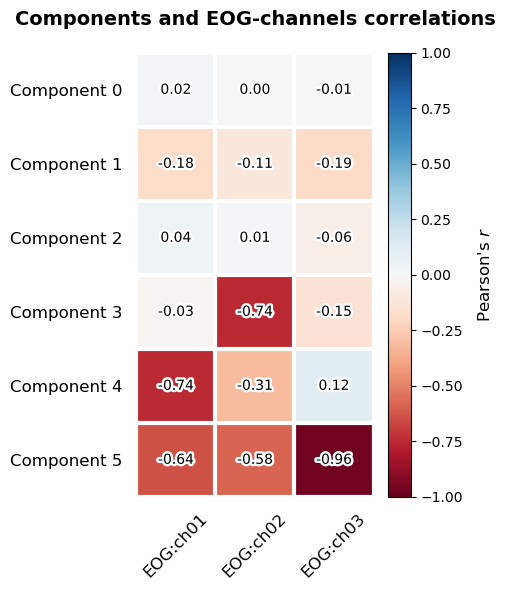

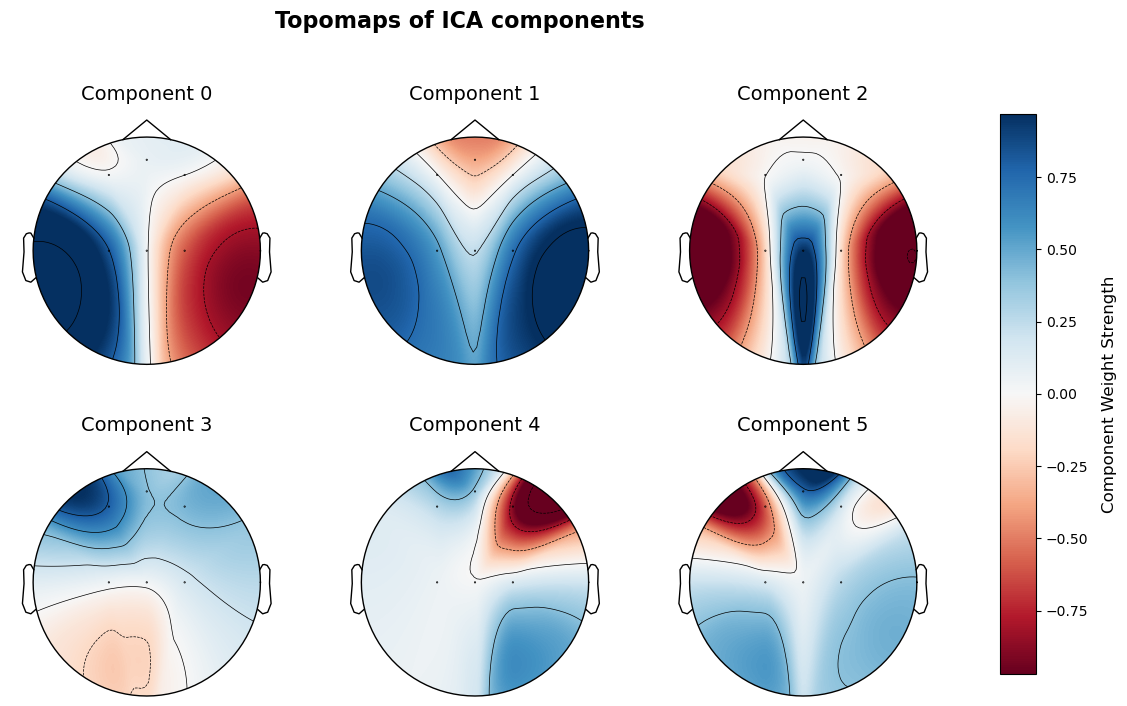

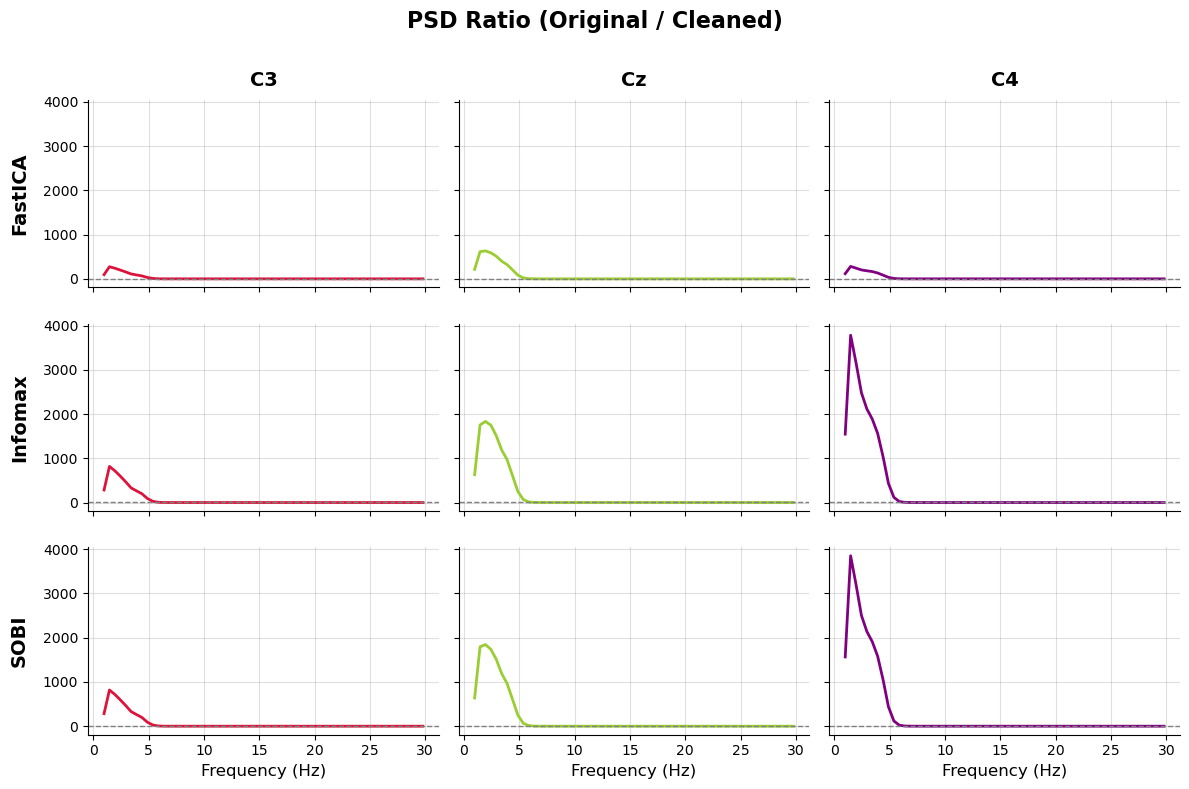

Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


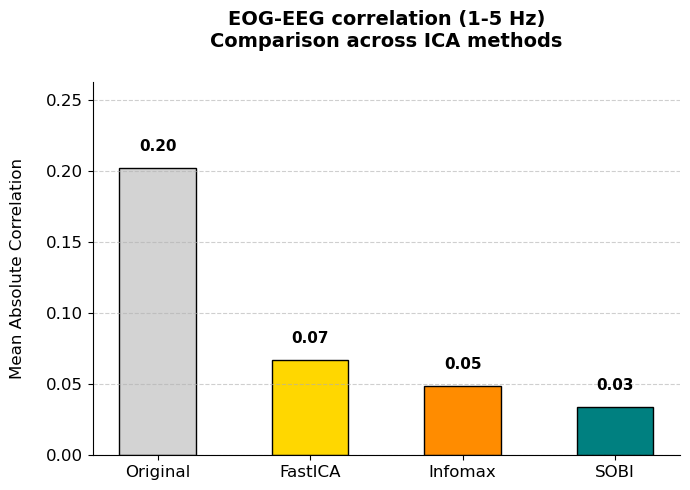

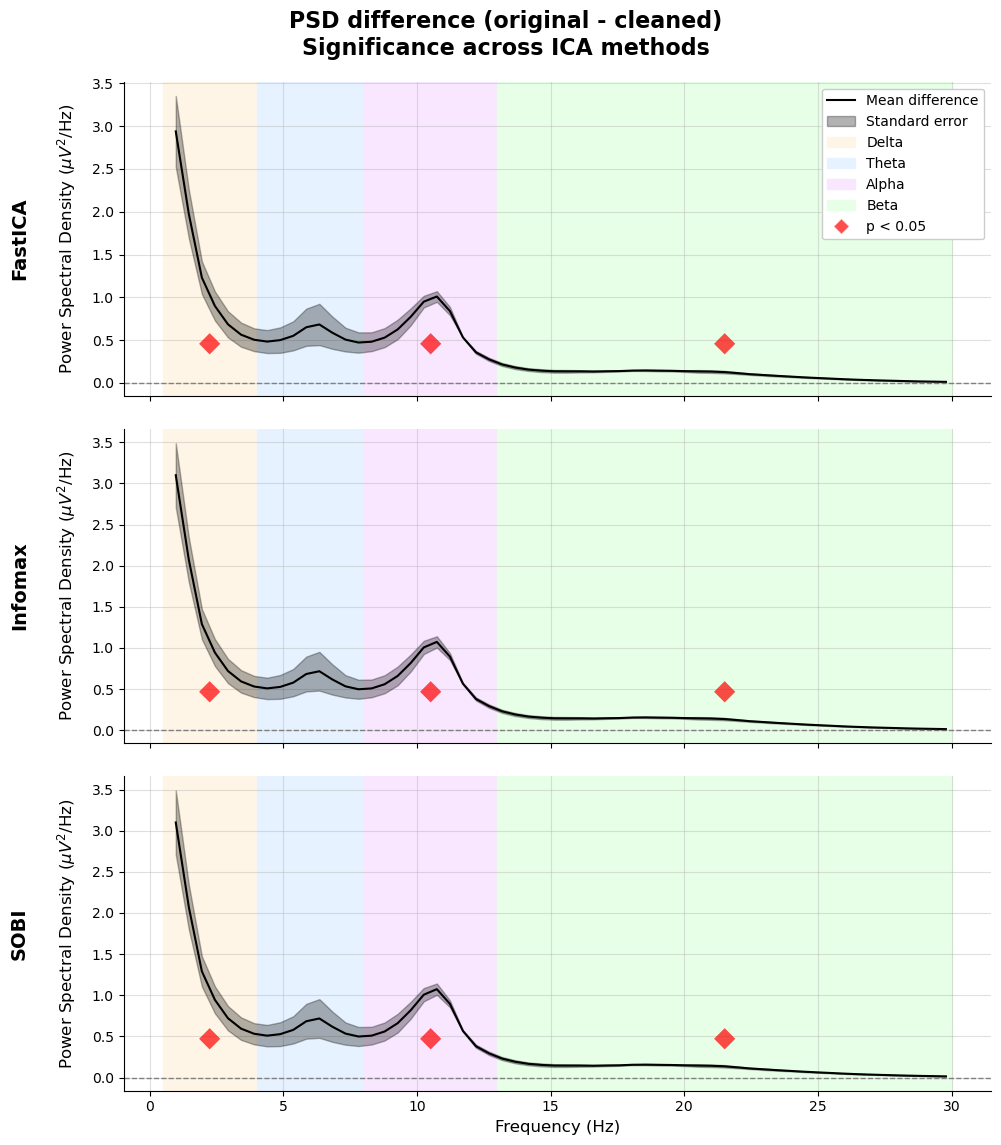

In [111]:
ch_names = train_df.columns.to_list()[-6:]

bands = {
    'Delta': (0.5, 4.0),
    'Theta': (4.0, 8.0),
    'Alpha': (8.0, 13.0),
    'Beta': (13.0, 30.0)
    }

visualize_results(filtered_X, results, ch_names, bands)